# **Data Preprocessing**

# **Dataset Loading**

**Dataset Selected — Garbage Classification**


The Garbage Classification Dataset is a computer vision dataset created to train and evaluate models that can classify waste into different categories, supporting smart waste management and recycling initiatives.

**This dataset can be used to:**

Build real-world applications for recycling, waste monitoring, and sustainability.

In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: habibahelal
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification


100%|██████████| 82.0M/82.0M [00:00<00:00, 1.04GB/s]

# **Data Preprocessing & Augmentation**

In [2]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import random

IMG_SIZE = (224, 224)

# Dynamically build class mapping
def build_class_mapping(txt_file, base_dir):
    mapping = {}
    with open(txt_file, "r") as f:
        lines = f.read().splitlines()

    for line in lines:
        fname, label_idx = line.strip().split()
        label_idx = int(label_idx)

        # find which folder contains this file
        for cls in os.listdir(base_dir):
            path = os.path.join(base_dir, cls, fname)
            if os.path.exists(path):
                mapping[label_idx] = cls
                break
    return mapping


def load_and_preprocess(txt_file, base_dir, class_mapping):
    data, labels = [], []

    with open(txt_file, "r") as f:
        lines = f.read().splitlines()

    for line in tqdm(lines, desc=f"Loading {os.path.basename(txt_file)}"):
        fname, label_idx = line.strip().split()
        label_idx = int(label_idx)
        class_name = class_mapping[label_idx]

        img_path = os.path.join(base_dir, class_name, fname)
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        data.append(img)
        labels.append(class_name)

    return np.array(data), np.array(labels)




In [3]:
base_dir = "/content/garbage-classification/garbage classification/Garbage classification"

# Build mapping from TRAIN file (consistent for val & test too)
class_mapping = build_class_mapping(
    "/content/garbage-classification/one-indexed-files-notrash_train.txt",
    base_dir
)
print("✅ Rebuilt class mapping:", class_mapping)

# Load splits
X_train, y_train = load_and_preprocess(
    "/content/garbage-classification/one-indexed-files-notrash_train.txt",
    base_dir, class_mapping
)

X_val, y_val = load_and_preprocess(
    "/content/garbage-classification/one-indexed-files-notrash_val.txt",
    base_dir, class_mapping
)

X_test, y_test = load_and_preprocess(
    "/content/garbage-classification/one-indexed-files-notrash_test.txt",
    base_dir, class_mapping
)

print("\nShapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print("Unique classes in train:", np.unique(y_train))


✅ Rebuilt class mapping: {3: 'cardboard', 2: 'paper', 1: 'glass', 5: 'metal', 6: 'trash', 4: 'plastic'}


Loading one-indexed-files-notrash_test.txt: 100%|██████████| 431/431 [00:01<00:00, 264.31it/s]



Shapes:
Train: (1768, 224, 224, 3) (1768,)
Val: (328, 224, 224, 3) (328,)
Test: (431, 224, 224, 3) (431,)
Unique classes in train: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [4]:
from collections import Counter

#augmentation function
def augment_image(img):

    # img is already normalized (0-1) ,Random horizontal flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1)

    # Random rotation (-20 to 20 degrees)
    angle = random.uniform(-20, 20)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    # Random width/height shift (-10% to 10%)
    tx = random.uniform(-0.1, 0.1) * w
    ty = random.uniform(-0.1, 0.1) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    # Random shear (-10% to 10%)
    shear = random.uniform(-0.1, 0.1)
    M = np.array([[1, shear, 0],
                  [0, 1, 0]], dtype=np.float32)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    # Random zoom (-10% to 10%)
    zx = 1 + random.uniform(-0.1, 0.1)
    zy = 1 + random.uniform(-0.1, 0.1)
    img = cv2.resize(img, None, fx=zx, fy=zy)
    # Crop or pad to original size
    if img.shape[0] > h:
        start_h = (img.shape[0]-h)//2
        img = img[start_h:start_h+h, :]
    else:
        pad_h = (h - img.shape[0])//2
        img = cv2.copyMakeBorder(img, pad_h, h-img.shape[0]-pad_h, 0, 0, cv2.BORDER_REPLICATE)
    if img.shape[1] > w:
        start_w = (img.shape[1]-w)//2
        img = img[:, start_w:start_w+w]
    else:
        pad_w = (w - img.shape[1])//2
        img = cv2.copyMakeBorder(img, 0, 0, pad_w, w-img.shape[1]-pad_w, cv2.BORDER_REPLICATE)

    # Random brightness (0.8x - 1.2x)
    img = np.clip(img * random.uniform(0.8, 1.2), 0, 1)

    return img

In [5]:
#Augment entire training dataset
X_train_aug = []
y_train_aug = []

for i in range(len(X_train)):
    X_train_aug.append(X_train[i])               # original
    y_train_aug.append(y_train[i])
    X_train_aug.append(augment_image(X_train[i])) # augmented
    y_train_aug.append(y_train[i])

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print("Original train size:", len(X_train))
print("Augmented train size:", len(X_train_aug))

Original train size: 1768
Augmented train size: 3536


# **Deep Learning & Transfer Learning for Waste Classification**

# **1. Baseline CNN**

* Build a simple custom CNN (Conv → Pool → Dense).

* Train on preprocessed + augmented dataset.

* Visualize training/validation accuracy & loss.

* Plot confusion matrix & classification report.

* Save model & architecture summary.

In [6]:
# Core
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics & Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels as integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Convert to one-hot
y_train_cat = to_categorical(y_train_enc, num_classes=6)
y_val_cat = to_categorical(y_val_enc, num_classes=6)
y_test_cat = to_categorical(y_test_enc, num_classes=6)


The model is a sequential CNN consisting of 10 layers. The initial layers are convolutional layers used to extract features from the input images. After the first two convolutional layers, max pooling layers are added to reduce the spatial dimensions and the number of parameters. The output from the convolutional layers, which contains the extracted image features, is flattened into a feature vector. This feature vector is then passed through two dense layers followed by a dropout layer to prevent overfitting. Finally, a dense layer with a softmax activation function outputs the predicted class among the six waste categories: plastic, glass, paper, metal, organic, and cardboard.

In [8]:
# Build model for garbage dataset
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=(1,1), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))  # 6 classes for garbage
    return model

In [9]:
model = build_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,794,374 (338.72 MB)

 Trainable params: 88,794,374 (338.72 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile model
model.compile(Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
print("X_train_aug:", X_train_aug.shape, X_train_aug.dtype)
print("y_train_cat:", y_train_cat.shape, y_train_cat.dtype)
print("X_val:", X_val.shape, X_val.dtype)
print("y_val_cat:", y_val_cat.shape, y_val_cat.dtype)


X_train_aug: (3536, 224, 224, 3) float64
y_train_cat: (3536, 6) float64
X_val: (328, 224, 224, 3) float64
y_val_cat: (328, 6) float64


In [13]:
X_train_aug = X_train_aug.astype("float32")
y_train_cat = y_train_cat.astype("float32")
X_val = X_val.astype("float32")
y_val_cat = y_val_cat.astype("float32")


In [14]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [15]:
history = model.fit(
    X_train_aug, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.2427 - loss: 1.8355 - val_accuracy: 0.4268 - val_loss: 1.4715
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.4297 - loss: 1.4220 - val_accuracy: 0.5335 - val_loss: 1.3043
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.5136 - loss: 1.2281 - val_accuracy: 0.5640 - val_loss: 1.2449
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5682 - loss: 1.1283 - val_accuracy: 0.6067 - val_loss: 1.1154
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6475 - loss: 0.9538 - val_accuracy: 0.6128 - val_loss: 1.0734
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6839 - loss: 0.8395 - val_accuracy: 0.6341 - val_loss: 1.1230
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.7317 - loss: 0.7344 - val_accuracy: 0.6311 - val_loss: 1.0215
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7952 - loss: 0.5802 - val_a

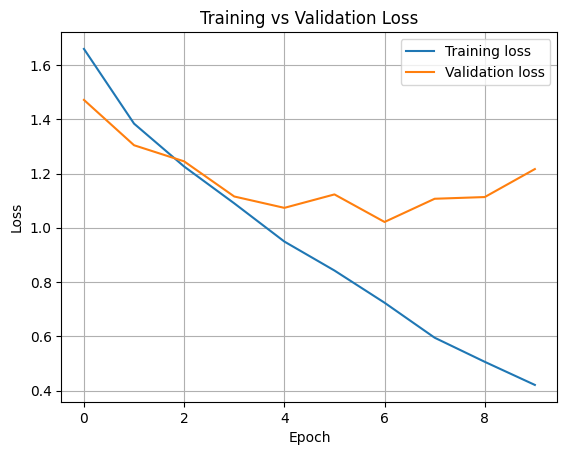

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


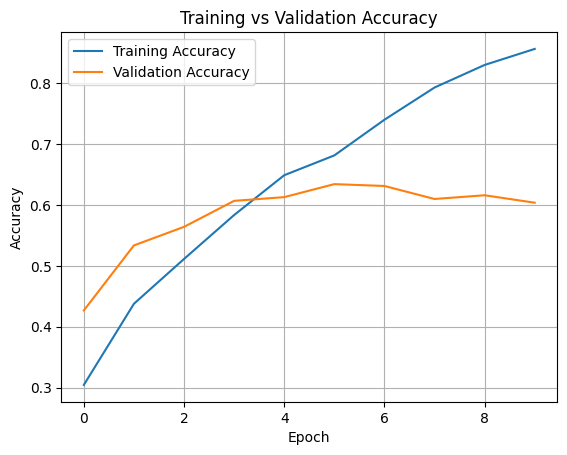

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Make sure x_test is normalized like training data
X_test = X_test.astype("float32") / 255.0

# Predict class probabilities
predictions = model.predict(X_test, batch_size=32)

# Convert probabilities -> class indices
predictions = np.argmax(predictions, axis=1)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


In [19]:
y_test = np.argmax(y_test_cat, axis=1)  # one-hot -> class indices


In [20]:
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test loss: 6.7055
Test Accuracy: 0.1903


In [21]:
model.save("garbage_cnn_model.h5")
print("Model saved as garbage_cnn_model.h5")


Model saved as garbage_cnn_model.h5


In [22]:
label_to_letter = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, predictions, target_names=list(label_to_letter.values())))


              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.19      1.00      0.32        82
       metal       0.00      0.00      0.00        68
       paper       0.00      0.00      0.00       108
     plastic       0.00      0.00      0.00        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.19       431
   macro avg       0.03      0.17      0.05       431
weighted avg       0.04      0.19      0.06       431



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


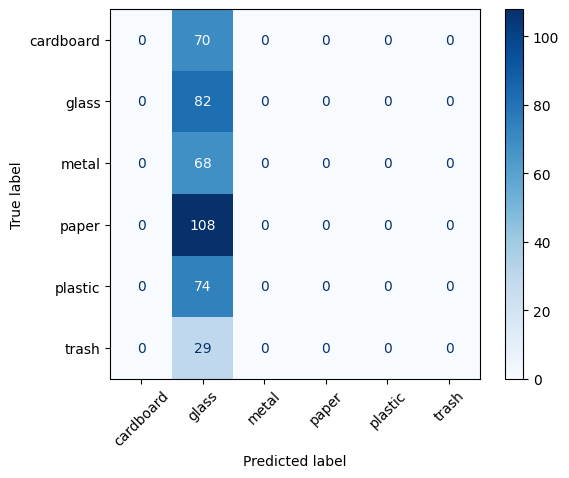

In [24]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_letter.values())).plot(
    cmap="Blues", xticks_rotation=45
)
plt.show()


**Results Interpretation**

Overall Accuracy = 0.19 (19%) → the model is barely better than random guessing (for 6 classes, random baseline ≈ 16%).

Glass:

Recall = 1.0 → the model predicts everything as glass.

Precision = 0.19 → only ~19% of predictions were actually glass.

All other classes: Precision, recall, f1-score = 0.0 → the model failed to learn them.

**Why this happened**

Class imbalance: your class weights hint that some classes (like trash) are underrepresented. The model may have collapsed into predicting the majority / easiest class.

CNN from scratch: with a small dataset (~3.5k training images), training a CNN from zero usually overfits or fails to generalize.

Insufficient training time / architecture: The CNN may not be deep enough to capture discriminative features for waste classification.

Image similarity: classes like cardboard/paper/plastic are visually close, making it harder without pretrained features.

**This is exactly why transfer learning is recommended:**

Pretrained models (VGG16, ResNet, EfficientNet) already learned robust visual features (edges, textures, shapes).

You only train the final dense layers → much higher accuracy on small datasets.

CNN is essentially collapsing to always predicting “glass” → hence the misleadingly high recall for that class and near-zero performance elsewhere.

**This makes a perfect justification to switch to transfer learning.**